In [49]:
#Importing Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, URL
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import joblib

In [3]:
# create MySQL database connection
url_object = URL.create(
    "mysql+mysqlconnector",
    username="root",
    password="Pudding@ice1",  # Special characters are handled automatically
    host="127.0.0.1",
    database="db_churn",
)

conn= create_engine(url_object)

In [13]:
df = pd.read_sql("select * from vw_ChurnData", conn)

In [19]:
df.head()

,Customer_ID,Gender,Age,Married,State,Number_of_Referrals,Tenure_in_Months,Value_Deal,Phone_Service,Multiple_Lines,...,Payment_Method,Monthly_Charge,Total_Charges,Total_Refunds,Total_Extra_Data_Charges,Total_Long_Distance_Charges,Total_Revenue,Customer_Status,Churn_Category,Churn_Reason
0,19877-DEL,Male,35.0,No,Delhi,7,27,,Yes,No,...,Credit Card,65.6,593.30,0.00,0.0,381.51,974.81,Stayed,,
1,58353-MAH,Female,45.0,Yes,Maharashtra,14,13,,Yes,Yes,...,Credit Card,-4.0,542.40,38.33,10.0,96.21,610.28,Stayed,,
2,25063-WES,Male,51.0,No,West Bengal,4,35,Deal 5,Yes,No,...,Bank Withdrawal,73.9,280.85,0.00,0.0,134.60,415.45,Churned,Competitor,Competitor had better devices
3,59787-KAR,Male,79.0,No,Karnataka,3,21,Deal 4,Yes,No,...,Bank Withdrawal,98.0,1237.85,0.00,0.0,361.66,1599.51,Churned,Dissatisfaction,Product dissatisfaction
4,28544-TAM,Female,80.0,No,Tamil Nadu,3,8,,Yes,No,...,Credit Card,83.9,267.40,0.00,0.0,22.14,289.54,Churned,Dissatisfaction,Network reliability


In [29]:
# drop columns that aren't necessary for prediction

df = df.drop(['Customer_ID', 'Churn_Category', 'Churn_Reason'], axis = 1)

In [39]:
# Lists of columns to be label encoded

columns_to_encode = [
    'Gender', 'Married', 'State', 'Value_Deal', 'Phone_Service', 'Multiple_Lines',
    'Internet_Service', 'Internet_Type', 'Online_Security', 'Online_Backup',
    'Device_Protection_Plan', 'Premium_Support', 'Streaming_TV', 'Streaming_Movies',
    'Streaming_Music', 'Unlimited_Data', 'Contract', 'Paperless_Billing',
    'Payment_Method'
]

#Encode cateegorical values exccept target variable
label_encoders = {}
for column in columns_to_encode:
    label_encoders[column] = LabelEncoder()
    df[column] = label_encoders[column].fit_transform(df[column])

# Manually encode the target variable 'Customer_Status'
df['Customer_Status'] = df['Customer_Status'].map({'Stayed' : 0, 'Churned' : 1})

#Split data into features and targets
X = df.drop('Customer_Status', axis = 1)
y = df['Customer_Status']

#split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)


In [41]:
# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Confusion Matrix:
[[788  53]
 [133 228]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.94      0.89       841
           1       0.81      0.63      0.71       361

    accuracy                           0.85      1202
   macro avg       0.83      0.78      0.80      1202
weighted avg       0.84      0.85      0.84      1202



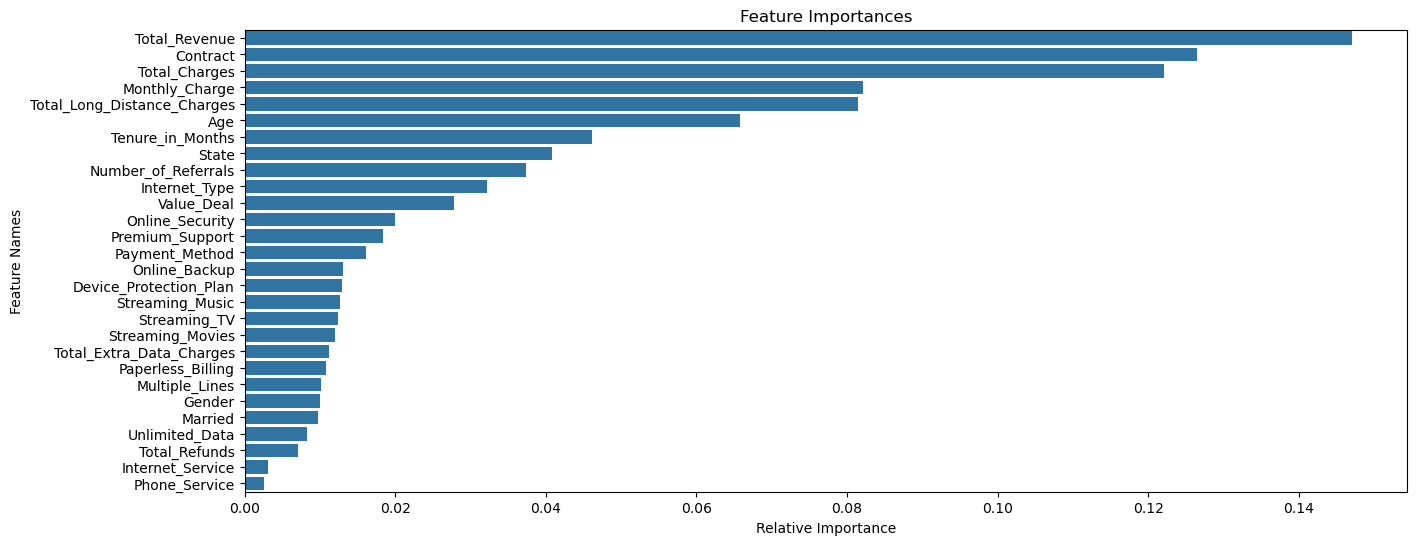

In [51]:
# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature Selection using Feature Importance
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(15, 6))
sns.barplot(x=importances[indices], y=X.columns[indices])
plt.title('Feature Importances')
plt.xlabel('Relative Importance')
plt.ylabel('Feature Names')
plt.show()


In [53]:
df2 = pd.read_sql("select * from vw_JoinData", conn)

In [55]:
df.head()

,Gender,Age,Married,State,Number_of_Referrals,Tenure_in_Months,Value_Deal,Phone_Service,Multiple_Lines,Internet_Service,...,Contract,Paperless_Billing,Payment_Method,Monthly_Charge,Total_Charges,Total_Refunds,Total_Extra_Data_Charges,Total_Long_Distance_Charges,Total_Revenue,Customer_Status
0,1,35.0,0,4,7,27,0,1,1,1,...,1,1,1,65.6,593.30,0.00,0.0,381.51,974.81,0
1,0,45.0,1,12,14,13,0,1,2,1,...,0,0,1,-4.0,542.40,38.33,10.0,96.21,610.28,0
2,1,51.0,0,21,4,35,5,1,1,1,...,0,1,0,73.9,280.85,0.00,0.0,134.60,415.45,1
3,1,79.0,0,9,3,21,4,1,1,1,...,0,1,0,98.0,1237.85,0.00,0.0,361.66,1599.51,1
4,0,80.0,0,17,3,8,0,1,1,1,...,0,1,1,83.9,267.40,0.00,0.0,22.14,289.54,1


In [57]:
# Retain the original DataFrame to preserve unencoded columns
original_data = df2.copy()

# Retain the Customer_ID column
customer_ids = df2['Customer_ID']

# Drop columns that won't be used for prediction in the encoded DataFrame
new_data = df2.drop(['Customer_ID', 'Customer_Status', 'Churn_Category', 'Churn_Reason'], axis=1)

# Encode categorical variables using the saved label encoders
for column in new_data.select_dtypes(include=['object']).columns:
    new_data[column] = label_encoders[column].transform(new_data[column])

# Make predictions
new_predictions = rf_model.predict(new_data)

# Add predictions to the original DataFrame
original_data['Customer_Status_Predicted'] = new_predictions

# Filter the DataFrame to include only records predicted as "Churned"
original_data = original_data[original_data['Customer_Status_Predicted'] == 1]


In [59]:
# save the results into the database
original_data.to_sql('churn_prediction', con = conn, if_exists = 'replace', index = False)

381

In [61]:
pd.read_sql('select * from churn_prediction', conn)

,Customer_ID,Gender,Age,Married,State,Number_of_Referrals,Tenure_in_Months,Value_Deal,Phone_Service,Multiple_Lines,...,Monthly_Charge,Total_Charges,Total_Refunds,Total_Extra_Data_Charges,Total_Long_Distance_Charges,Total_Revenue,Customer_Status,Churn_Category,Churn_Reason,Customer_Status_Predicted
0,93520-GUJ,Female,67.0,No,Gujarat,13,19,Deal 5,Yes,Yes,...,72.10,72.1,0.0,0.0,7.77,79.87,Joined,,,1
1,57256-BIH,Female,18.0,No,Bihar,9,7,,Yes,No,...,19.85,57.2,0.0,0.0,9.36,66.56,Joined,,,1
2,72357-MAD,Female,53.0,No,Madhya Pradesh,14,12,Deal 5,Yes,No,...,44.30,44.3,0.0,0.0,42.95,87.25,Joined,,,1
3,66612-KAR,Female,58.0,Yes,Karnataka,11,18,,Yes,No,...,19.95,58.0,0.0,0.0,8.07,66.07,Joined,,,1
4,22119-WES,Male,31.0,Yes,West Bengal,5,5,,Yes,No,...,20.05,33.7,0.0,0.0,3.62,37.32,Joined,,,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376,21065-HAR,Male,27.0,No,Haryana,5,10,,Yes,No,...,20.30,20.3,0.0,0.0,10.84,31.14,Joined,,,1
377,31412-HAR,Female,81.0,Yes,Haryana,14,29,,Yes,No,...,19.20,37.2,0.0,0.0,14.06,51.26,Joined,,,1
378,54997-UTT,Female,55.0,No,Uttar Pradesh,7,23,,Yes,No,...,44.00,44.0,0.0,0.0,26.15,70.15,Joined,,,1
379,56728-RAJ,Male,40.0,No,Rajasthan,0,1,,Yes,No,...,45.60,45.6,0.0,0.0,37.44,83.04,Joined,,,1
